In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import real_amplitudes, zz_feature_map
from qiskit_machine_learning.optimizers import COBYLA, L_BFGS_B
from qiskit_machine_learning.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import qnn_circuit

In [2]:
import numpy as np

import numpy as np

num_samples = 200
eps = 0.2
lb, ub = -np.pi, np.pi

f = lambda x: (np.sin(5.0 * x) + 0.5 * np.sin(8.0 * x)) / 4.0 + 0.5

X = np.linspace(lb, ub, num_samples)
y = f(X) + eps * (2 * np.random.rand(num_samples) - 1)


# --- PAA over a single block ---
def paa_1d(y, n_segments: int):
    segments = np.array_split(np.arange(len(y)), n_segments)
    return np.array([y[idx].mean() for idx in segments])


# --- sliding-window PAA dataset ---
def build_paa_dataset(y, raw_window_len: int, n_segments: int = 11):
    """
    From a single long time series y:
      - take sliding raw windows
      - compute PAA for each window
      - inputs = first 10 PAA segments
      - target = 11th PAA segment
    """
    X_paa = []
    y_paa = []

    for start in range(len(y) - raw_window_len + 1):
        raw_block = y[start : start + raw_window_len]

        paa_y = paa_1d(raw_block, n_segments)

        X_paa.append(paa_y[:-1])   # 10 inputs
        y_paa.append(paa_y[-1])    # 1-step-ahead target

    return np.array(X_paa), np.array(y_paa)


# --- build dataset ---
raw_window_len = 110   # e.g. ~10 raw points per PAA segment
n_segments = 11

X_paa, y_paa = build_paa_dataset(y, raw_window_len, n_segments)

print("X_paa shape:", X_paa.shape)   # (num_windows, 10)
print("y_paa shape:", y_paa.shape)   # (num_windows,)


X_paa shape: (91, 10)
y_paa shape: (91,)


In [3]:
print(X_paa[0])
print("→", y_paa[0])


[0.38916375 0.25739288 0.62059416 0.6876263  0.25588789 0.43198546
 0.66515803 0.67739813 0.40510956 0.19527049]
→ 0.691251749271812


In [4]:
print("num examples:", len(X_paa))
print("X range:", float(X_paa.min()), float(X_paa.max()))
print("y range:", float(y_paa.min()), float(y_paa.max()))


num examples: 91
X range: 0.12367372171684318 0.8103454255523838
y range: 0.12367372171684318 0.7610241279717972


In [5]:
print("first target:", y_paa[0])
print("second target:", y_paa[1])
print("delta:", float(y_paa[1] - y_paa[0]))


first target: 0.691251749271812
second target: 0.7078731606633349
delta: 0.016621411391522956


In [6]:
y_mean = float(y_paa.mean())
mse_baseline = float(np.mean((y_paa - y_mean) ** 2))
print("baseline mean predictor MSE:", mse_baseline)


baseline mean predictor MSE: 0.030250568309871294


In [7]:
rho1 = np.corrcoef(y_paa[:-1], y_paa[1:])[0, 1]
print("lag-1 autocorrelation:", rho1)


lag-1 autocorrelation: 0.9804041966791124


In [8]:
from qiskit.primitives import StatevectorEstimator as Estimator

estimator = Estimator()

In [9]:
from qiskit.circuit.library import zz_feature_map, real_amplitudes

num_qubits = 10
ansatz = real_amplitudes(num_qubits, reps=3)

In [10]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

def lag1_zz_feature_map_trainable(num_qubits: int):
    """
    Lag-1 feature map with trainable ZZ coupling.
    Local encoding: RY(x_i)
    Lag-1 entanglement: theta_i * x_i * x_{i+1}
    """
    x = ParameterVector("x", length=num_qubits)
    theta = ParameterVector("theta", length=num_qubits - 1)

    qc = QuantumCircuit(num_qubits, name="FM_LAG1_ZZ_TRAINABLE")

    # local encoding (amplitude-sensitive)
    for i in range(num_qubits):
        qc.rx(x[i], i)

    # lag-1 trainable entanglement
    for i in range(num_qubits - 1):
        qc.cx(i, i + 1)
        qc.rz(theta[i] * x[i] * x[i + 1], i + 1)
        qc.cx(i, i + 1)

    return qc, x, theta


In [11]:
feature_map, x_params, theta_params = lag1_zz_feature_map_trainable(num_qubits=10)


No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


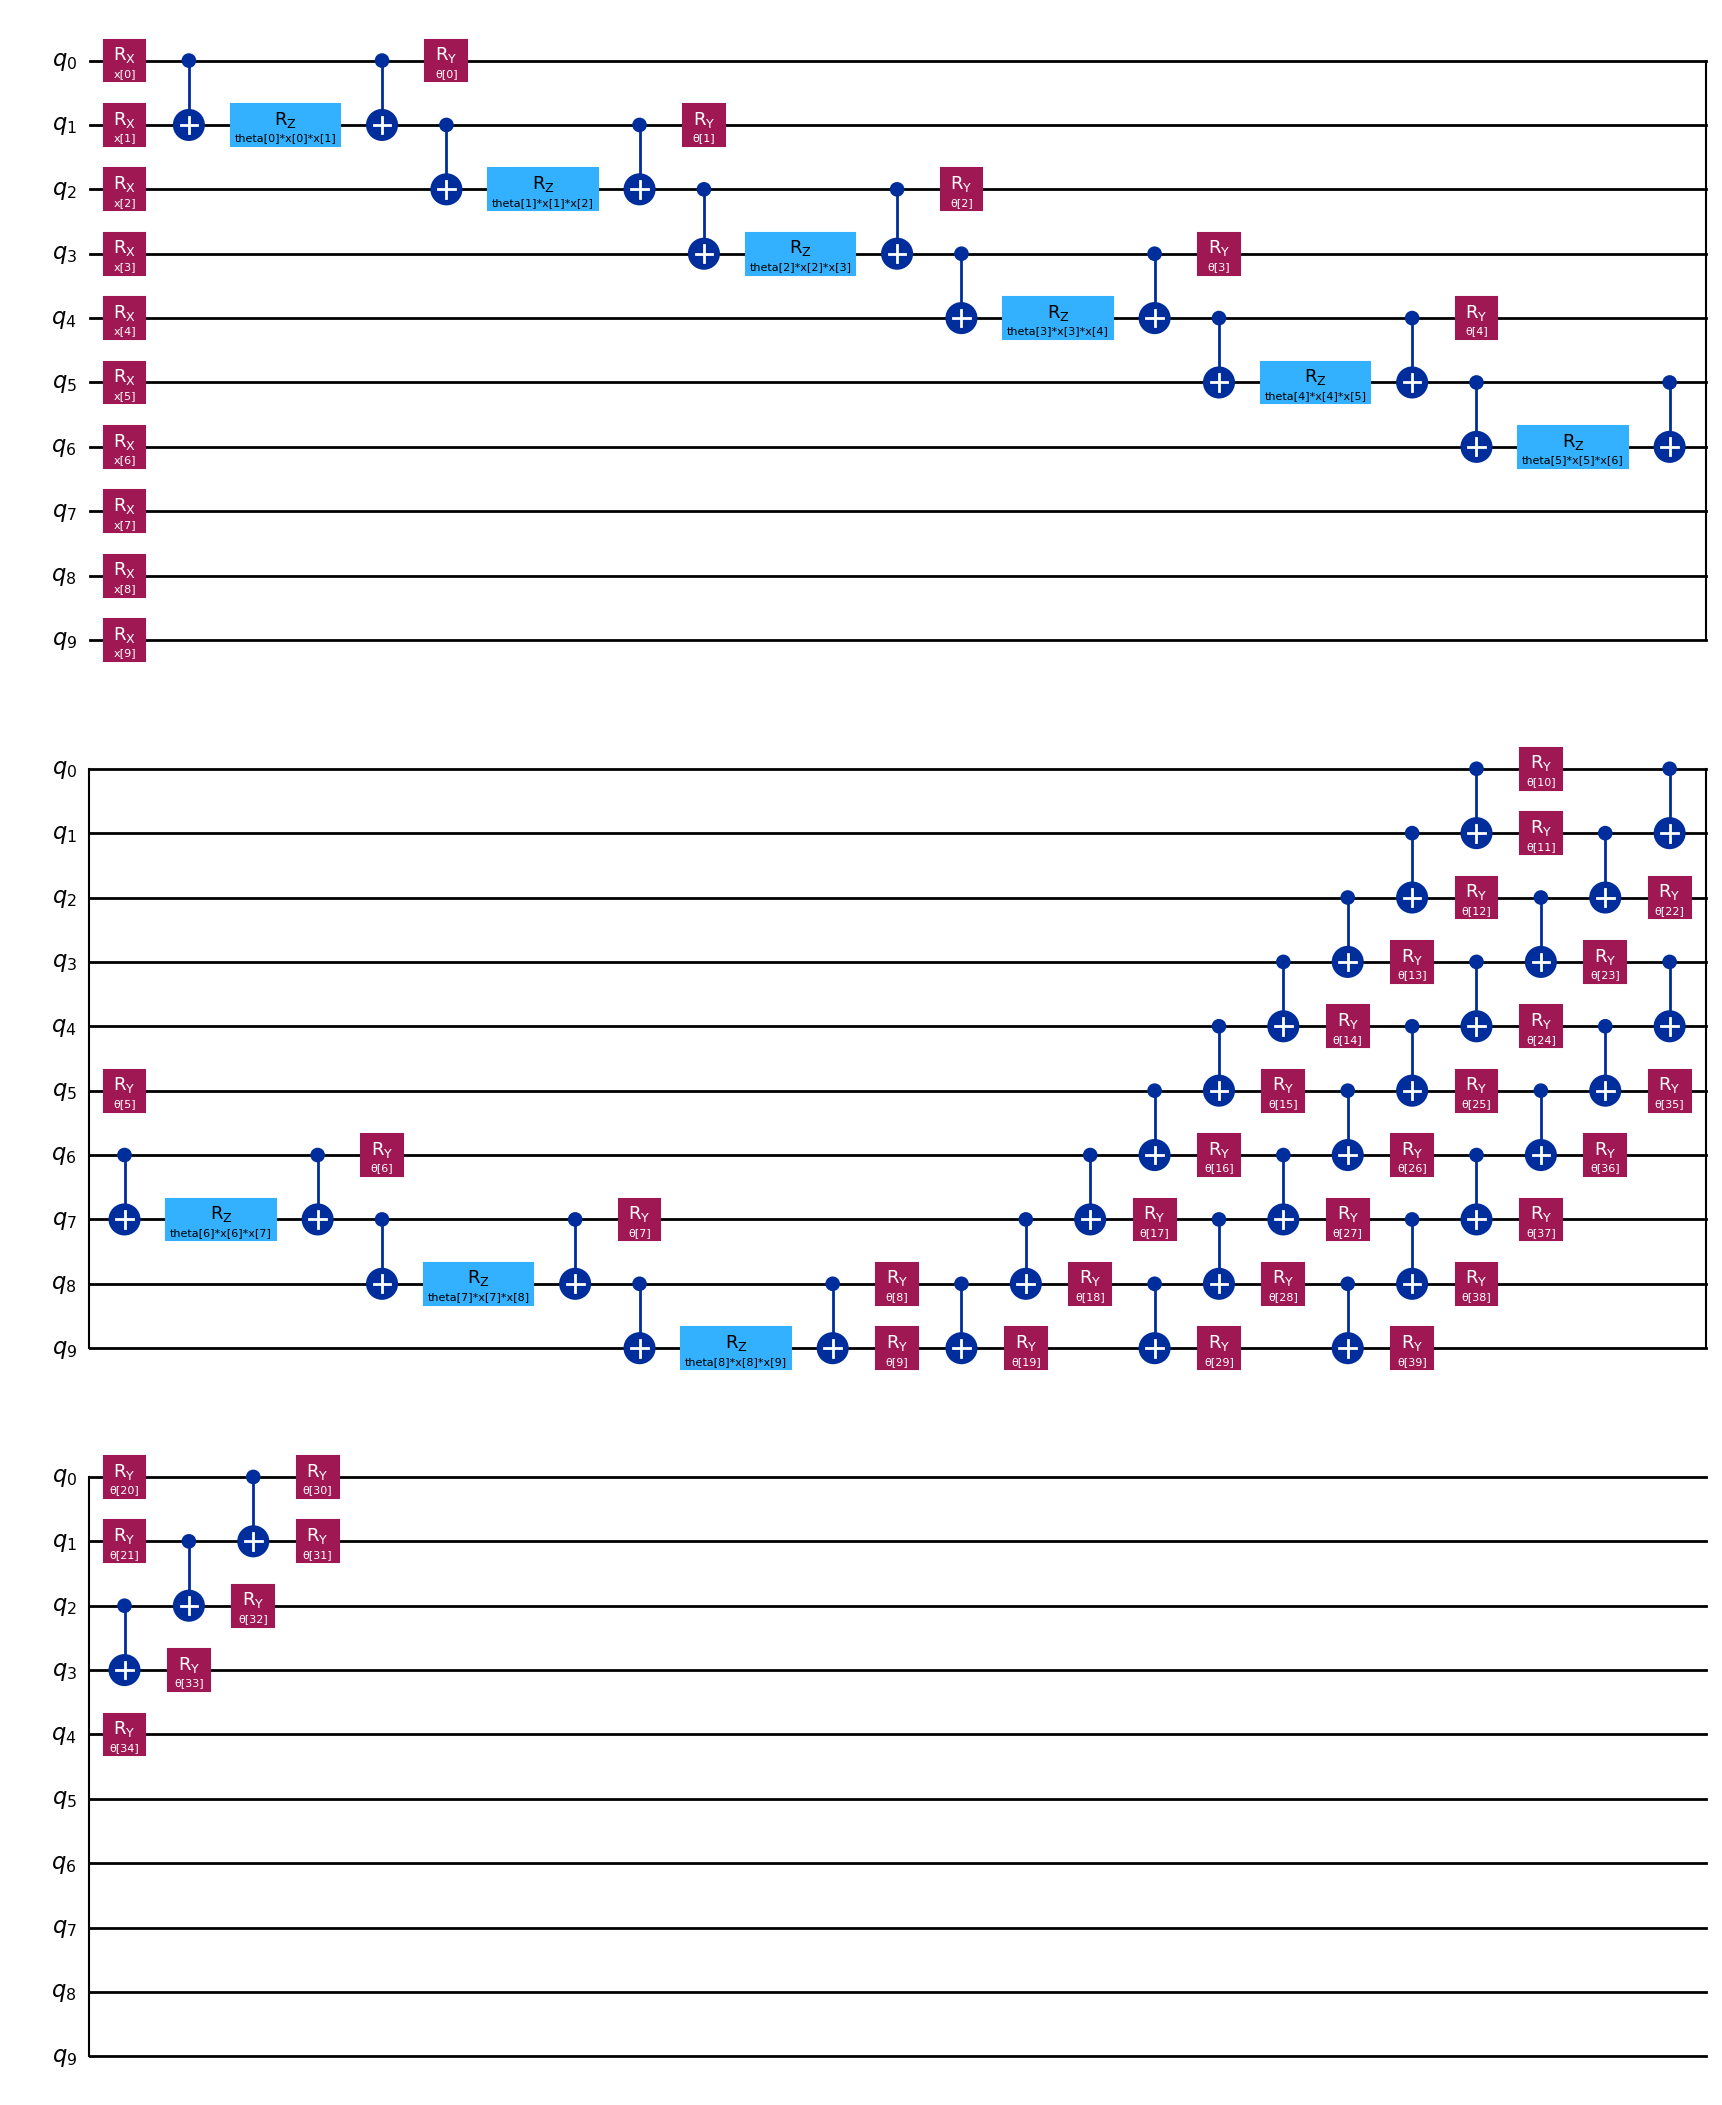

In [12]:
qc, fm_params, anz_params = qnn_circuit(feature_map=feature_map, ansatz=ansatz)

# construct QNN
qnn = EstimatorQNN(
    circuit=feature_map.compose(ansatz),
    input_params=list(x_params),
    weight_params=list(theta_params) + list(ansatz.parameters),
    estimator=estimator,
)

qc.draw("mpl")

In [13]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph_nnr(weights, obj_func_eval):
        clear_output(wait=True)
        objective_func_vals_nnr.append(obj_func_eval)
        plt.title("Objective function value against iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Objective function value")
        plt.plot(range(len(objective_func_vals_nnr)), objective_func_vals_nnr, "b.-")
        plt.show()

In [14]:
regressor = NeuralNetworkRegressor(
    neural_network=qnn,
    loss="squared_error",
    optimizer=COBYLA(maxiter=200),
    callback=callback_graph_nnr,
)

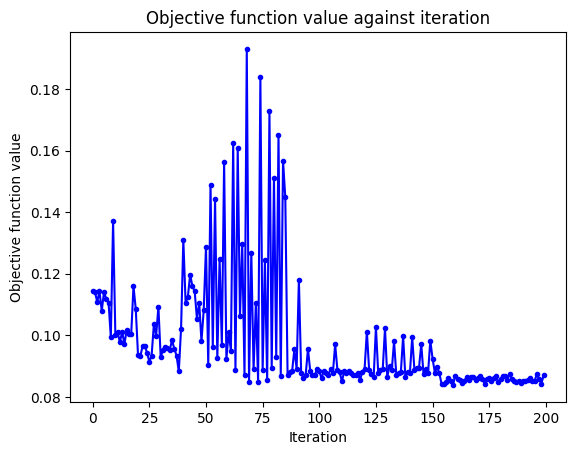

X_win shape: (91, 10)
score: 0.29437017190460946


In [15]:
import numpy as np

# assumes you already built:
#   X_paa: (num_examples, 10)
#   y_paa: (num_examples,)
# from the dataset block

X_win = X_paa
y_next = y_paa

# --- scale for angle encoding + expectation-style output ---
scale = 2 * np.pi

# scale inputs (angles)
X_win_s = X_win * scale

# scale targets to [-1, 1]
y_next_s = 2 * y_next - 1

objective_func_vals_nnr = []

# fit
regressor.fit(X_win_s, y_next_s)

# score
score = regressor.score(X_win_s, y_next_s)
print("X_win shape:", X_win.shape)
print("score:", score)


In [16]:
from sklearn.metrics import mean_squared_error

# predict on training data (scaled)
y_pred_s = regressor.predict(X_win_s)

# invert scaling back to [0,1]
y_pred = 0.5 * (y_pred_s + 1)

# compute MSE in original space
mse = mean_squared_error(y_next, y_pred)
print("MSE:", mse)


MSE: 0.02159248152896413


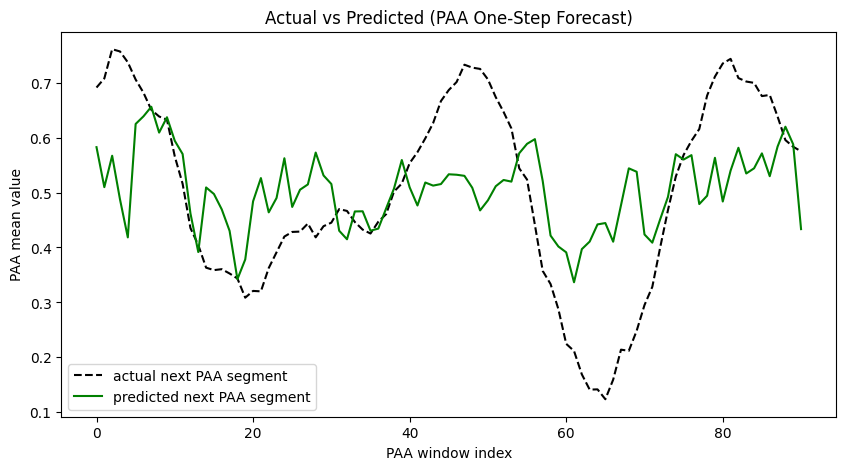

In [17]:
# --- actual vs predicted (next PAA segment) ---
# y_paa: true next-segment targets
# y_pred: predicted next-segment values

t = np.arange(len(y_paa))  # PAA window index (time index in compressed space)

plt.figure(figsize=(10, 5))
plt.plot(t, y_paa, "k--", label="actual next PAA segment")
plt.plot(t, y_pred, "g-", label="predicted next PAA segment")
plt.xlabel("PAA window index")
plt.ylabel("PAA mean value")
plt.title("Actual vs Predicted (PAA One-Step Forecast)")
plt.legend()
plt.show()


In [ ]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph_vqr(weights, obj_func_eval):
        clear_output(wait=True)
        objective_func_vals_vqr.append(obj_func_eval)
        plt.title("Objective function value against iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Objective function value")
        plt.plot(range(len(objective_func_vals_vqr)), objective_func_vals_vqr, "b.-")
        plt.show()

In [ ]:

vqr = VQR(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer = COBYLA(maxiter=500),
    callback=callback_graph_vqr,
    estimator=estimator,
)

In [ ]:
# --- build 10D inputs via sliding windows ---
order = np.argsort(X[:, 0])
y_sorted = y[order]

window = 10

X_win = np.array(
    [y_sorted[i : i + window] for i in range(len(y_sorted) - window)]
)
y_next = np.array(
    [y_sorted[i + window] for i in range(len(y_sorted) - window)]
)

# --- build dense windows for prediction ---
X_dense = X_[:, 0]
y_dense = f(X_dense)

X_dense_win = np.array(
    [y_dense[i : i + window] for i in range(len(y_dense) - window)]
)

# create empty array for callback to store evaluations of the objective function
objective_func_vals_vqr = []
plt.rcParams["figure.figsize"] = (12, 6)

scale = 2 * np.pi

# scale inputs (angles)
X_win_s = X_win * scale
X_dense_win_s = X_dense_win * scale

# scale targets to [-1, 1]
y_next_s = 2 * y_next - 1

# fit
vqr.fit(X_win_s, y_next_s)

# predict (scaled), then invert back to [0,1]
y_pred_s = vqr.predict(X_dense_win_s)
y_pred = 0.5 * (y_pred_s + 1)

print("pred_s range:", float(np.min(y_pred_s)), float(np.max(y_pred_s)))
print("pred range:", float(np.min(y_pred)), float(np.max(y_pred)))

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score on the same scaled representation used for training
score = vqr.score(X_win_s, y_next_s)
print("score:", score)


In [ ]:

y_actual = y_dense[window:]

plt.figure(figsize=(10, 5))
plt.plot(X_pred, y_actual, "k--", label="actual next value")
plt.plot(X_pred, y_pred, "g-", label="predicted next value")
plt.xlabel("x")
plt.ylabel("PAA value")
plt.title("Actual vs Predicted (Next-Step Forecast)")
plt.legend()
plt.show()
